Load relevant libraries.

In [1]:
import os
import numpy as np
import torch
import torchvision
import cv2
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt
from torchvision import transforms as T

Use pretrained models from PyTorch and set them in eval mode.  
Note: choose `fasterrcnn_resnet50fpn` and three other models named: `model0, model1, model2, model3`.

In [2]:
# Download a pretrained model
model0 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model1 = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)
model2 = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model3 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# Inference
model0.eval()
model1.eval()
model2.eval()
model3.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 54.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `Non

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


MS-COCO class names list and utilities

In [3]:
# Defing PyTorch Transform
transform = T.Compose([T.ToTensor()])

# Define class names from MS-COCO dataset

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Write a Python function that takes an image, model variable, and confidence threshold as input, and returns a list of predicted boxes and a list of predicted classes.


In [5]:
def get_detection(img, model, threshold=0.5):
  pred = model([img]) # Pass the image to the model

  # pred is a list and each element of that list is a dictionary with keys: "labels", "scores", and "boxes"
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Classes
  pred_boxes = pred[0]['boxes']  # Get the Prediction Boxes
  pred_score = pred[0]['scores']  # Get the Prediction Scores
  try:
      pred_t = torch.nonzero(pred_score > threshold, as_tuple=False)[-1] # Get (last) list of index with score greater than threshold.
  except:
      pred_t = 0
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  #print(pred_boxes)
  #print(pred_class)

  return pred_boxes, pred_class

Use Matplotlib to write a function that takes an image path as input & uses `get_detection` to obtain a list of boxes and classes, and displays the detections.
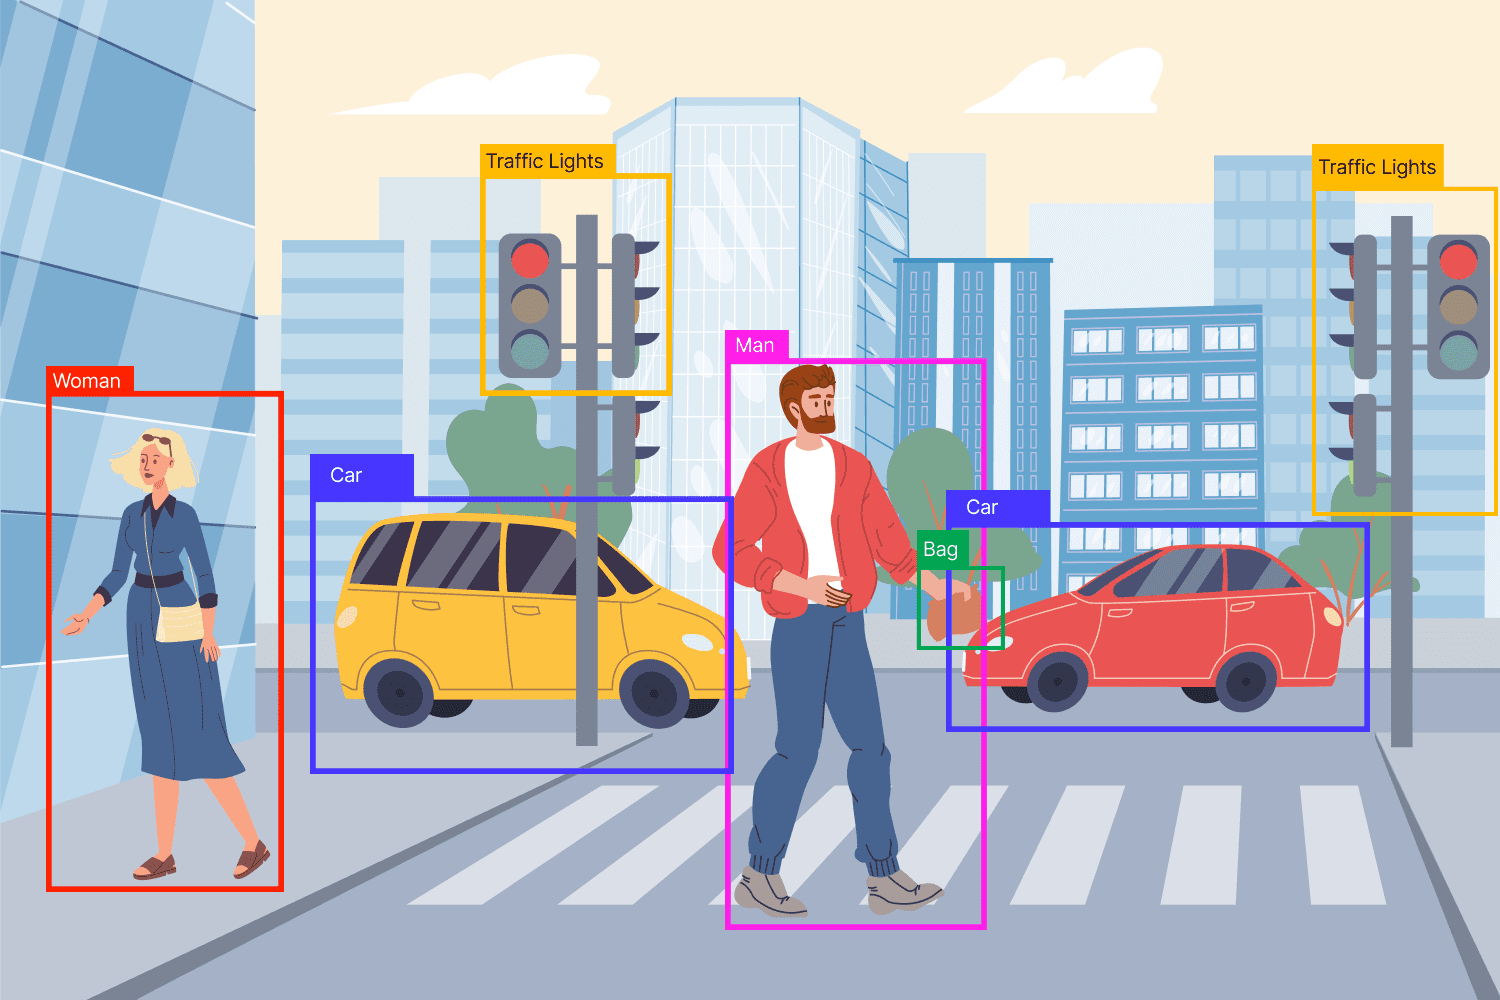

In [6]:
def show_detections(img_path, model, threshold=0.5):
  img = Image.open(img_path).convert('RGB') # Load the image as RGB w/ 3 channels
  img1 = transform(img) # Apply the transform to the image
  boxes, pred_cls = get_detection(img1, model, threshold) # Get predictions
  img2 = cv2.imread(img_path) # Read image with cv2
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # Convert to RGB
  # display the image, overlay the bounding boxes and predicted classes on top of the image

  draw = ImageDraw.Draw(img)  # enable bb draw for img
  for box, cls in zip(boxes, pred_cls):
      box = [int(coord) for coord in box] # grab all coords from box
      draw.rectangle(box, outline="yellow", width=2)  # draw bb
      draw.text((box[0], box[1]), f"{cls}", fill="red")   # add label

  plt.figure(figsize=(8,14)) # display the output image
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

  plt.show()

Show the detections using all four models for `img_path=https://www.tejasgokhale.com/images/vehicle.png` and another image (`https://www.bridgedetroit.com/wp-content/uploads/2023/05/children-riding-bike.jpg`)

--2023-12-07 21:55:50--  https://www.tejasgokhale.com/images/vehicle.png
Resolving www.tejasgokhale.com (www.tejasgokhale.com)... 185.199.109.153, 185.199.108.153, 185.199.110.153, ...
Connecting to www.tejasgokhale.com (www.tejasgokhale.com)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581854 (568K) [image/png]
Saving to: ‘vehicle.jpg’

vehicle.jpg         100%[===================>] 568.22K  3.51MB/s    in 0.2s    

2023-12-07 21:55:52 (3.51 MB/s) - ‘vehicle.jpg’ saved [581854/581854]

--2023-12-07 21:55:52--  https://www.bridgedetroit.com/wp-content/uploads/2023/05/children-riding-bike.jpg
Resolving www.bridgedetroit.com (www.bridgedetroit.com)... 192.0.78.197, 192.0.78.158
Connecting to www.bridgedetroit.com (www.bridgedetroit.com)|192.0.78.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214718 (1.2M) [image/jpeg]
Saving to: ‘children.jpg’

children.jpg        100%[===================>]   1.16M  1.79MB/s    

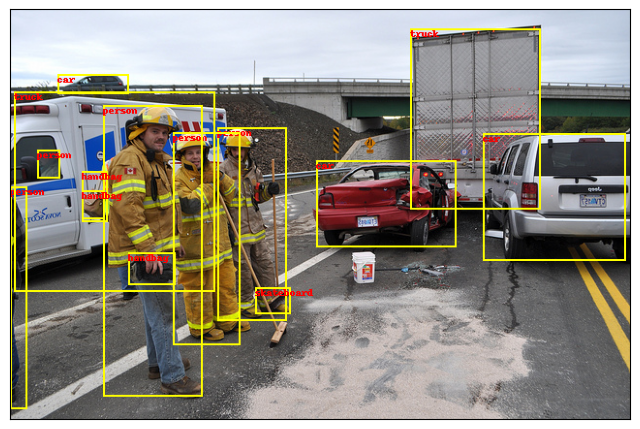

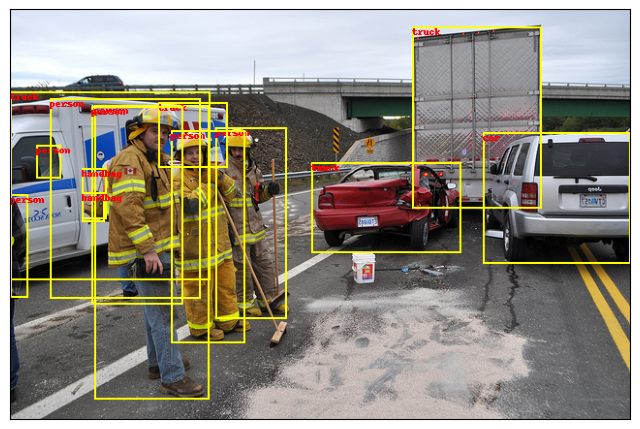

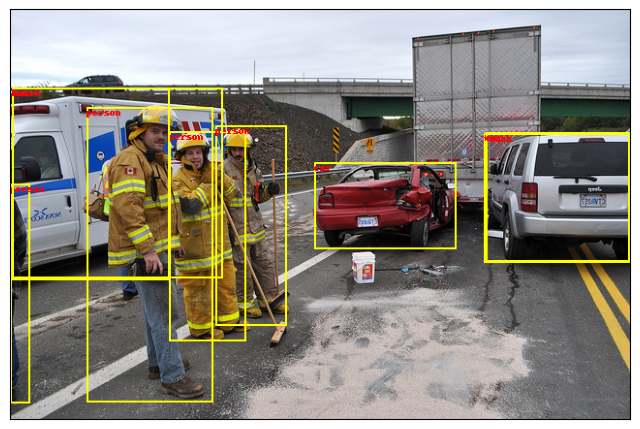

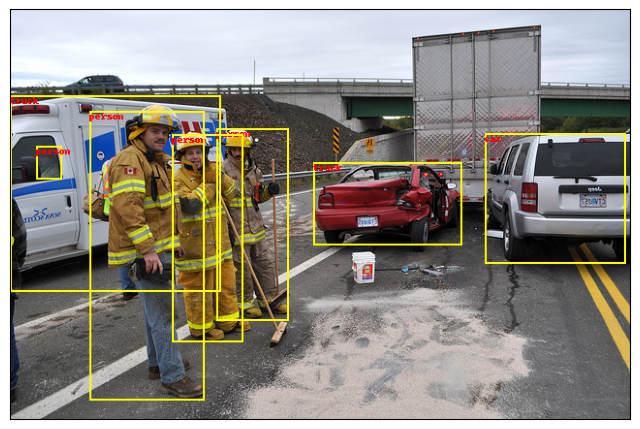

In [8]:
!wget https://www.tejasgokhale.com/images/vehicle.png -O vehicle.jpg
!wget -O children.jpg https://www.bridgedetroit.com/wp-content/uploads/2023/05/children-riding-bike.jpg

# use show_detections to display results for model0,model1,model2,model3
show_detections('vehicle.jpg', model0)
show_detections('vehicle.jpg', model1)
show_detections('vehicle.jpg', model2)
show_detections('vehicle.jpg', model3)




U use MS-COCO dataset (https://cocodataset.org/)
The code below walks you through downloading and loading images and annotations from the COCO dataset.

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2023-12-05 23:22:16--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.129.153, 52.217.174.25, 52.216.210.97, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.129.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  65.0MB/s    in 13s     

2023-12-05 23:22:29 (62.1 MB/s) - ‘coco_val2017.zip’ saved [815585330/815585330]

--2023-12-05 23:22:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.10.11, 54.231.131.89, 52.216.170.219, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.10.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%

In [ ]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [ ]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

Now we will use the above dataloader to test the first 100 images from COCO

In [ ]:
def eval_iou(GT_bound_box, pred_box):
    """
    # To calc IoU:
    #   intersection: get min() from each of the y's img top corners, get min() from both img bottom corners
    #
    #   union:  area of bb1 + area of bb2 - intersection
    #           calc area as |top left corner y - bottom left corner y| * |top left corner x - top right corner x|
    """
    # get pred bb coords
    bot_left_x, bot_left_y = pred_box[:2]
    top_right_x, top_right_y = pred_box[2:]

    # formatting
    bot_left_x = bot_left_x.item()
    bot_left_y = bot_left_y.item()
    top_right_x = top_right_x.item()
    top_right_y = top_right_y.item()

    # get area of pred bb
    pred_h = np.abs(bot_left_x - top_right_x)
    pred_w = np.abs(bot_left_y - top_right_y)
    pred_area = pred_h * pred_w

    GT_bot_left_x, GT_bot_left_y = GT_bound_box[:2]
    GT_w, GT_h = GT_bound_box[2:]
    GT_area = GT_w * GT_h

    #calc intersection
    inter_bot_x = max(GT_bot_left_x, bot_left_x) # for bot left corner
    inter_bot_y = max(GT_bot_left_y, bot_left_y)
    inter_top_x = min(GT_bot_left_x + GT_w, top_right_x) # for top right corner
    inter_top_y = min(GT_bot_left_y + GT_h, top_right_y)
    bb_w = np.abs(inter_bot_x - inter_top_x)
    bb_h = np.abs(inter_top_y - inter_bot_y)

    intersection = bb_w * bb_h
    IoU = intersection / (GT_area + pred_area - intersection)
    return IoU

In [ ]:
coco_annotations_file="./coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="./coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

img_ids = coco.get_imgIds() # has 100(?) imgs (ids)
img_ids = img_ids[:20]   # choosing 100 img

def COCO_test(model):
    iou_scores = [] # store iou scores for a model
    TP_amount = 0
    FP_amount = 0
    FN_amount = 0
    # !!!! calculate the meanIOU over the entire dataset of 100 images
    # !!!! report the meanIOU for all 4 models
    for i, im in enumerate(img_ids):
        image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg") # load img
        image = transform(image)

        pred_boxes, pred_class = get_detection(image, model) # predict bb and labels for an img
        ann_ids = coco.get_annIds(im)
        annotations = coco.load_anns(ann_ids)
        FP_amount += np.abs(len(pred_class) - len(annotations))

        for ann in annotations:
            gt_bbox = ann['bbox']
            gt_class_id = ann["category_id"]
            cat_id = coco.load_cats(gt_class_id) # load ids to get ann class
            # print(cat_id)

            # find which instance/bb in pred matches the annotation and get its iou score
            if cat_id[0]['name'] in pred_class:
                temp_ious = []
                for i in range(len(pred_class)):
                    if pred_class[i] == cat_id[0]['name']:
                        # compare bb of matching classes
                        iou = eval_iou(gt_bbox, pred_boxes[i])
                        if iou <= 1:
                            temp_ious.append(iou)

                # keep only score best matching instance (most likely the right bb)
                if (temp_ious):
                    iou_scores.append(max(temp_ious))
                TP_amount += 1
            else:   # an annotated object (real) was NOT in the predictions
                FN_amount += 1

    precision = TP_amount / (TP_amount + FP_amount)
    recall = TP_amount / (TP_amount + FN_amount)

    print(model.name)
    print("\tMean IOU score from 100 COCO images:\t", np.mean(iou_scores))
    print("\tPrecision:\t", precision)
    print("\tRecall:\t", recall)

In [ ]:
# Test for each of the four models
model0.name = 'fasterrcnn_resnet50_fpn'
model1.name = 'fcos_resnet50_fpn'
model2.name = 'fasterrcnn_mobilenet_v3_large_fpn'
model3.name = 'retinanet_resnet50_fpn'

COCO_test(model0)
COCO_test(model1)
COCO_test(model2)
COCO_test(model3)